# <span style='color: lightcoral;'> 여러 가지 확률분포 </span>

데이터는 데이터 사이언스, 머신러닝 등 다양한 분야에서 중심적인 역할을 합니다. 시간이 지남에 따라 다양한 분야에서 주어진 데이터에 근거하여 결정을 내리고, 혁신적인 상품을 개발하는 데 있어서도 데이터가 점점 더 중요해지고 있습니다. 

여러분이 기초 통계학에서 배운 기본적인 확률 분포를 토대로 이 강의에서는 다음 내용들을 공부합니다. 

1) 특정 확률분포를 따르는 데이터를 랜덤하게 생성하는 방법을 살펴봅니다. (다시 말해, 특정 확률분포를 따르는 랜덤 샘플 생성기를 만듭니다.)

2) 여러 가지 확률분포를 따르는 랜덤 샘플 생성기를 활용해서 인위적으로 개 품종의 특성 데이터를 생성하고, 이 데이터를 학습하는 나이브 베이즈 분류기(Naive Bayes clssifier)를 구현해 봅니다. 

## <span style='color:blue'>0. 실습 준비 작업 </span>

- 우선 필요한 모듈을 읽어들입니다. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from math import factorial
from scipy.special import erfinv, comb
from scipy.stats import uniform, binom, norm
from dataclasses import dataclass
from sklearn.metrics import accuracy_score

- 파이썬의 딕셔너리 자료형과 같은 JSON 데이터를 보기 좋게 출력하기 위해 `pprint` 모듈도 읽어들입니다. 
 >- `pprint` 모듈에는 한 개의 클래스 `pprint.PrettyPrinter`가 정의되어 있는데, 출력하는 너비나 깊이 등을 다른 상황으로 설정해 놓고 편하게 사용하고 싶으면 다른 속성을 가진 클래스의 인스턴스들을 각각 생성해 놓고 `pprint` method를 이용하면 예쁜 출력을 얻을 수 있습니다. 
 $$ $$
 >- 익숙하지 않을 수 있으므로 예를 들어 보겠습니다. 

In [2]:
import pprint 

In [3]:
# `pprint`모듈의 `pprint.PrettyPrinter`클래스의 객체로 생성된 인스턴스의 `pprint` 함수 사용 예 사용 예

sample_proj = {'author': 'The Python Packaging Authority','author_email': 'pypa-dev@googlegroups.com','bugtrack_url': None,
'classifiers': ['Development Status :: 3 - Alpha','Intended Audience :: Developers','License :: OSI Approved :: MIT License',
                 'Programming Language :: Python :: 3','Programming Language :: Python :: 3.2','Programming Language :: Python :: 3.3',
                 'Topic :: Software Development :: Build Tools']}
print(sample_proj)
print("*****************")
pprint.pprint(sample_proj)   # print()와 출력 차이를 확인하세요.         

{'author': 'The Python Packaging Authority', 'author_email': 'pypa-dev@googlegroups.com', 'bugtrack_url': None, 'classifiers': ['Development Status :: 3 - Alpha', 'Intended Audience :: Developers', 'License :: OSI Approved :: MIT License', 'Programming Language :: Python :: 3', 'Programming Language :: Python :: 3.2', 'Programming Language :: Python :: 3.3', 'Topic :: Software Development :: Build Tools']}
*****************
{'author': 'The Python Packaging Authority',
 'author_email': 'pypa-dev@googlegroups.com',
 'bugtrack_url': None,
 'classifiers': ['Development Status :: 3 - Alpha',
                 'Intended Audience :: Developers',
                 'License :: OSI Approved :: MIT License',
                 'Programming Language :: Python :: 3',
                 'Programming Language :: Python :: 3.2',
                 'Programming Language :: Python :: 3.3',
                 'Topic :: Software Development :: Build Tools']}


- 클래스 생성자 `pprint.PrettyPrinter()`로 출력 형태에 맞는 인스턴스를 생성할 수 있습니다. (여기서는 너비, 깊이는 기본값 그대로)

In [4]:
#  `??pprint`를 실행시켜 실제 `pprint.py` 파일에 클래스 하나만 정의되어 있을을 확인  

In [4]:
pp = pprint.PrettyPrinter()  # 기본값으로 인스턴스 생성 
pp1 = pprint.PrettyPrinter(depth=1) # `depth`(출력하는 깊이를 1단계까지만)

pp.pprint(sample_proj)
print("***************")
print("***************")
pp1.pprint(sample_proj)  # 아래 출력을 보고 비교

{'author': 'The Python Packaging Authority',
 'author_email': 'pypa-dev@googlegroups.com',
 'bugtrack_url': None,
 'classifiers': ['Development Status :: 3 - Alpha',
                 'Intended Audience :: Developers',
                 'License :: OSI Approved :: MIT License',
                 'Programming Language :: Python :: 3',
                 'Programming Language :: Python :: 3.2',
                 'Programming Language :: Python :: 3.3',
                 'Topic :: Software Development :: Build Tools']}
***************
***************
{'author': 'The Python Packaging Authority',
 'author_email': 'pypa-dev@googlegroups.com',
 'bugtrack_url': None,
 'classifiers': [...]}


### <span style='color:orange'> 강의에 필요한 유틸리티 함수들 정의 </span>
- 특정 분포를 따르는 랜덤 샘플의 배열 세 개에 대해, 히스토그램을 그려주는 함수 세 가지를 정의 

> `plot_exponential_distributions` : 랜덤 샘플이 지수분포를 따르는지 시각적으로 확인하는 함수  

> `plot_gaussian_distributions` : 랜덤 샘플이 정규분포를 따르는지 시각적으로 확인하는 함수  

> `plot_binomial_distributions` : 랜덤 샘플이 이항분포를 따르는지 시각적으로 확인하는 함수  

In [5]:
# 그래프를 그리는 함수

def plot_exponential_distributions(exponential_0, exponential_1, exponential_2, density=False):
    fig, axes = plt.subplots(1, 3, sharey=True, figsize=(10, 4))
    axes[0].hist(exponential_0, density=density, alpha=0.5, bins=32)
    axes[1].hist(exponential_1, density=density, alpha=0.5, bins=32)
    axes[2].hist(exponential_2, density=density, alpha=0.5, bins=32)
    
    axes[0].set_title("Histograms of exponential_0")
    axes[1].set_title("Histograms of exponential_1")
    axes[2].set_title("Histograms of exponential_2")
    
    axes[0].set_xlabel("Values")
    axes[1].set_xlabel("Values")
    axes[2].set_xlabel("Values")
    axes[0].set_ylabel("Frequencies")
    plt.show()
    

def plot_gaussian_distributions(gaussian_0, gaussian_1, gaussian_2):
    fig, ax = plt.subplots(1, 1, figsize=(10, 4))
    ax.hist(gaussian_0, alpha=0.5, label="gaussian_0", bins=32)
    ax.hist(gaussian_1, alpha=0.5, label="gaussian_1", bins=32)
    ax.hist(gaussian_2, alpha=0.5, label="gaussian_2", bins=32)
    ax.set_title("Histograms of Gaussian distributions")
    ax.set_xlabel("Values")
    ax.set_ylabel("Frequencies")
    ax.legend()
    plt.show()
    
    
def plot_binomial_distributions(binomial_0, binomial_1, binomial_2):
    fig, ax = plt.subplots(1, 1, figsize=(10, 4))
    ax.hist(binomial_0, alpha=0.5, label="binomial_0")
    ax.hist(binomial_1, alpha=0.5, label="binomial_1")
    ax.hist(binomial_2, alpha=0.5, label="binomial_2")
    ax.set_title("Histograms of Binomial distributions")
    ax.set_xlabel("Values")
    ax.set_ylabel("Frequencies")
    ax.legend()
    plt.show()

## <span style='color:blue'> 1. 특정 확률분포를 따르는 랜덤 샘플 생성하기 </span>

연속확률변수 $X$의 확률밀도함수를 $f$, 누적분포함수를 $F$라 할 때,  

 >- $$F(x)={\rm P}(X\le x)=\int_{-\infty}^x f(x)\,dx$$   
 $$ $$
- $[0,1]$에서의 균등분포(uniform distribution)를 따르는 확률변수  $U$와 어떤 확률변수의 누적분포함수 $F$에 대해 확률변수  $Y=F^{-1}(U)$의 누적분포함수를 구하면 

 >-    $$\begin{aligned}{\rm P}(0\le Y\le y)=&{\rm P}(0\le F^{-1}(U)\le y)\\
    =&{\rm P}(0\le U\le F(y))\\
    =&F(y)
    \end{aligned}$$  
    이므로 $Y$의 누적분포함수는 $F(y)$입니다. (위 계산의 마지막 등식은 균등분포를 따르는 확률변수 $U$에 대한 확률 계산)
    
- 따라서, 누적분포 $F$를 따르는 랜덤 샘플을 생성하는 방법은 $[0,1]$에서 균등분포를 따르는 샘플 $u$를 생성하고, $F^{-1}(u)$를 계산하면 되죠.  

 >- 예를 들어, 지수분포(확률밀도함수가 $f(x)=\lambda e^{-\lambda x}$)를 따르는 샘플을 생성하기 위해서 $F(x)$를 구하면 
 $$F(x)=\int_{-\infty}^x \lambda e^{-\lambda x}\,dx=1-e^{-\lambda x}$$
 이고 
 $$F^{-1}(x)=-\dfrac{1}{\lambda}\ln(1-x)$$
 
 >- $[a,b)$에서의 균등분포를 따르는 램덤 샘플을 $n$개 생성하는 내장 함수는 `np.random.uniform(a,b,n)`과 같이 넘파이 배열로 생성할 수 있습니다. 
    $$ $$  

$$ $$

이산확률변수 $X$의 확률질량함수를 $f$, 누적분포함수를 $F$라 하면
$$F(x)={\rm P}(X\le x)=\sum_{x_i \le x}f(x_i)$$
이므로, $F(x)$는 구간에서 상수인 계단함수가 됩니다. 따라서 연속확률변수의 경우처럼 균등분포의 역함수를 구할 수 없습니다.  

>- 하지만, 이 경우에도 균등분포를 이용하여 $[0,1)$ 사이의 값 $r$을 랜덤하게 생성하고, $F(x_i)< r \le F(x_{i+1})$를 만족하는 최소의 $x_{i+1}$을 반환하는 형태로 주어진 이산분포를 따르는 랜덤 샘플을 생성할 수 있습니다. 

>- 이처럼 연속확률변수의 경우 CDF의 역함수 역할을 하는 함수를 `일반화된 CDF의 역함수` 또는 `분위수 함수(quantile)`이라고 부르고 정확하게는 다음과 같이 정의합니다. 
$$F^{-1}(p)=\text{inf}\{x\in \mathbb R|F(x)\ge p\}\quad (0\le p \le 1)$$

>- 예를 들어, $0$과 $1$이 나올 확률이 똑같이 $\frac 12 $인 베르누이 분포의 누적분포함수를 $F(x)$라 할 때, 
$$ $$
$$F(x)=\begin{cases} 0 & \ (x<0)\\ \frac 1 2 &\ (0\le x <1)\\ 1 &\ (x\ge 1)\end{cases}$$
$$ $$
입니다. 따라서, 균등분포로 생성된 난수 $r$에 대해 분위수 함숫값 $F^{-1}(r)$을 구하면
$$ $$
$$
F^{-1}(r)=\begin{cases} 0 & \ (0\le r \le 0.5)\\ 1 & (0.5< r \le 1)\end{cases}
$$
$$ $$
과 같이 베르누이 분포를 따르는 랜덤 샘플을 생성하는 것이죠. 


$$ $$

이제, 알려진 분포를 따르는 데이터를 인위적으로 생성할 수 있습니다! 

>- 우선, 모든 랜덤 샘플 생성기의 기본이 되는 균등분포에 대한 랜덤 샘플 생성기부터 직접 구현해보고, 

>- 이를 이용해서 위 예에서 설명한 지수분포를 따르는 랜덤 샘플 생성기를 만들어 보겠습니다. 

>- 그 다음에 자주 사용되는 이항분포와 정규분포에 대한 랜덤 샘플 생성 방법을 다뤄보도록 하죠. 


### <span style="color:blue"> 1.1 균등분포를 따르는 랜덤 샘플 생성기</span>

어떤 확률분포를 따르는 랜덤 샘플을 생성하려면, 가장 기본이 되는 것이 균등분포에 대한 랜덤 샘플 생성기입니다. 

- 컴퓨터에서 어떤 프로그램을 이용하여 $[0,1)$ 사이에 속하는 값을 랜덤하게 보이도록 생성할 수 있는데, 이를 유사 난수(pseudo-random number)라고 부릅니다.(즉, 실제로는 어떤 규칙을 이용하여 랜덤하게 보이는 수열을 생성하는 것입니다. 이 때 수열의 초깃값을 난수의 씨앗(seed)라고 합니다. 이 강의에서는 유사 난수 생성기 [pseudo-random number generator](https://en.wikipedia.org/wiki/Pseudorandom_number_generator)는 깊이 다루지 않습니다. (관심이 있는 학생은 앞에서 링크한 웹페이지를 참고하세요.)

- 이 강의에서는 넘파이 내장함수 `np.random.random(n)`를 유사 난수 생성기로 생각하고 이를 기반으로 구현하도록 하겠습니다. (즉, 이 함수는 $[0,1)$에서 균등균포를 따르는 랜덤 샘플 $n$개를 반환하는 함수입니다.) 
 
 >- 넘파이에서 난수와 관련된 모듈 `random`의 `random.seed()`를 이용하면 유사 난수기의 초깃값을 설정할 수 있습니다. (동일한 초깃값에 대해서 동일한 시뮬레이션 결과를 얻길 원할 때 사용)

- 이제 $[a,b)$에서 균등분포를 따르는 랜덤 샘플 $n$개를 반환하는 함수 `uniform_generator(a,b,n)`을 구현해보죠.

In [7]:
def uniform_generator(a, b, num_samples=100, rand_seed=42):
    """
    Generates an array of uniformly distributed random numbers within the specified range.

    Parameters:
    - a (float): The lower bound of the range.
    - b (float): The upper bound of the range.
    - num_samples (int): The number of samples to generate (default: 100).

    Returns:
    - array (ndarray): An array of random numbers sampled uniformly from the range [a, b).
    """    
    
    array = (b-a) * np.random.random(num_samples) + a
    return array

- 작성한 함수를 시험해 보죠. 

 >- 사실은 넘파이 내장함수로 이미 `np.random.uniform(a,b,num_samples)`가 구현되어 있습니다. 작성한 함수와 비교해보죠. 
 
 >- `np.random.seed`의 의미도 확인해 보겠습니다. 
 
 >- 아래 코드에서 `np.array2string`함수는 넘파이 배열을 문자열로 바꿔주는 함수입니다. 

- 우선, 아래 두 셀의 실행 결과를 보고 `np.random.seed()`의 의미를 확인해보세요. 

In [8]:
np.random.seed(42)
print(f"6 randomly generated values between 0 and 1:\n{np.array2string(uniform_generator(0, 1, 6), precision=3)}\n")
print(f"6 randomly generated values between 0 and 1:\n{np.array2string(uniform_generator(0, 1, 6), precision=3)}\n")

6 randomly generated values between 0 and 1:
[0.375 0.951 0.732 0.599 0.156 0.156]

6 randomly generated values between 0 and 1:
[0.058 0.866 0.601 0.708 0.021 0.97 ]



In [9]:
np.random.seed(42)
print(f"6 randomly generated values between 0 and 1:\n{np.array2string(uniform_generator(0, 1, 6), precision=3)}\n")
np.random.seed(42)
print(f"6 randomly generated values between 0 and 1:\n{np.array2string(uniform_generator(0, 1, 6), precision=3)}\n")

6 randomly generated values between 0 and 1:
[0.375 0.951 0.732 0.599 0.156 0.156]

6 randomly generated values between 0 and 1:
[0.375 0.951 0.732 0.599 0.156 0.156]



- 넘파이에서 사용하는 `np.random`모듈의 유사 난수기의 초기값을 `np.random.seed`로 설정하고 나면, 다음 초깃값을 설정할 때까지 규칙에 따라 일정한 순서로 랜덤하게 보이는 수가 반환됩니다. 

>- 위의 첫 번째 셀에서는 처음에 한 번만 초기화를 시켰고, 두 번째 셀에서는 매 번 초기화를 시킨 결과입니다. 차이점이 보이죠?

>- 이처럼 랜덤한 샘플을 이용한 실험을 할 때는 시행할 때마다 동일한 결과를 확인하기 위해 유사 난수기의 초깃값을 `np.random.seed`로 설정합니다.

In [10]:
# `uniform_generator` 테스트 

np.random.seed(42)
print(f"6 randomly generated values between 0 and 1:\n{np.array2string(uniform_generator(0, 1, 6), precision=3)}\n")
print(f"3 randomly generated values between 20 and 55:\n{np.array2string(uniform_generator(20, 55, 6), precision=3)}\n")
print(f"1 randomly generated value between 0 and 100:\n{np.array2string(uniform_generator(0, 100, 1), precision=3)}")

6 randomly generated values between 0 and 1:
[0.375 0.951 0.732 0.599 0.156 0.156]

3 randomly generated values between 20 and 55:
[22.033 50.316 41.039 44.783 20.72  53.947]

1 randomly generated value between 0 and 100:
[83.244]


In [11]:
# 넘파이 내장함수 `np.random.uniform` 테스트

np.random.seed(42)
print(f"6 randomly generated values between 0 and 1:\n{np.array2string(np.random.uniform(0, 1, 6), precision=3)}\n")
print(f"3 randomly generated values between 20 and 55:\n{np.array2string(np.random.uniform(20, 55, 6), precision=3)}\n")
print(f"1 randomly generated value between 0 and 100:\n{np.array2string(np.random.uniform(0, 100, 6), precision=3)}")

6 randomly generated values between 0 and 1:
[0.375 0.951 0.732 0.599 0.156 0.156]

3 randomly generated values between 20 and 55:
[22.033 50.316 41.039 44.783 20.72  53.947]

1 randomly generated value between 0 and 100:
[83.244 21.234 18.182 18.34  30.424 52.476]


- <span style='color:orange'>위 두 셀의 테스트 결과를 보면 직접 구현한 함수 `uniform_generator`와 넘파이 내장함수 `np.random.uniform`의 결과가 동일함을 알 수 있습니다. </span>

### <span style="color:blue"> 1.2 지수분포를 따르는 랜덤 샘플 생성기</span>

- 이제 균등분포를 따르는 랜덤 샘플을 생성하는 함수 `uniform_generator`를 만들었으므로, 특정 분포를 따르는 랜덤 샘플을 생성하기 위한 최소 조건은 마련했습니다.

- 앞서 특정 확률분포를 따르는 랜덤 샘플을 설명할 때 예로 들었던 지수분포에 대해 랜덤 샘플 생성기를 구현해 보겠습니다. 

 >- 모수가 $\lambda$에 대해 확률밀도함수(PDF)가 $f(x)=\lambda e^{-\lambda x}$인 지수분포는 보통 $\text{Exp}(\lambda)$로 나타내는데, 앞서 계산한 CDF의 역함수  $F^{-1}(y)=-\dfrac{1}{\lambda}\ln(1-y)$를 `inverse_cdf_exponential`이란 이름으로 작성하고,  
 
 >- 이 함수를 이용해서 지수분포를 따르는 랜덤 샘플 생성기 `exponential_generator`를 구현해보죠. 

In [12]:
def inverse_cdf_exponential(y,lamb):
    return -(1/lamb) * np.log(1 - y)

def exponential_generator(lamb, num_samples):
    # 입력으로 전달된 개수만큼 0과 1사이에서 균등분포를 따르는 랜덤 샘플 생성
    u = uniform_generator(0, 1, num_samples)

    # 정규분포에 대한 CDF의 역함수를 이용하여 원하는 랜덤 샘플 생성
    array = inverse_cdf_exponential(u, lamb)  # ndarray에 대해 함수를 계산하면 각 성분별로 함수가 적용되는 것 기억하죠?
    return array

- 생성한 랜덤 샘플이 지수분포를 따르는지 히스토그램을 그려서 시각적으로 확인 

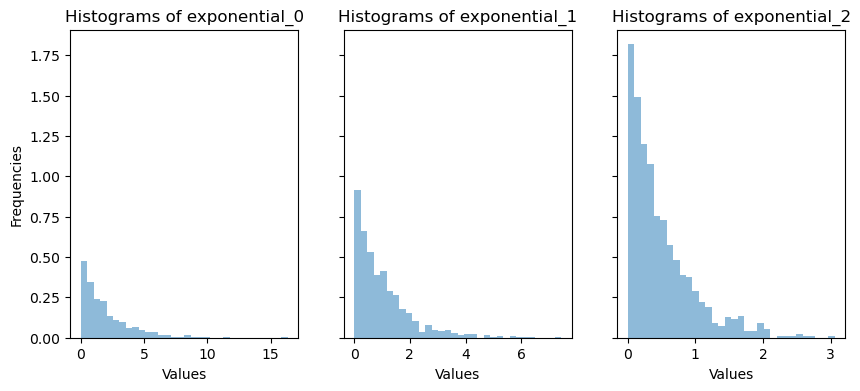

In [13]:
exponential_0 = exponential_generator(0.5, 1000)
exponential_1 = exponential_generator(1, 1000)
exponential_2 = exponential_generator(2, 1000)

plot_exponential_distributions(exponential_0, exponential_1, exponential_2, density=True)

### <span style="color:blue"> 1.3 정규분포를 따르는 랜덤 샘플 생성기</span>
 
- 정규분포를 따르는 랜덤 샘플을 생성하기 위해 필요한 것은 누적분포함수(CDF)의 역함수를 구현하는 것입니다. 

### <span style="color:blue">1.3.1 정규분포: 누적분포함수의 역함수 </span>

- 가우시안 분포(Gaussian distribution)라고도 부르는 정규분포는 평균이 $\mu$이고 표준편차가 $\sigma$일 때 $\text{N}(\mu,\sigma^2)$으로 나타내고, 확률변수 $X$에 대한 확률밀도함수 $f(x)$가 
$$f(x)=\dfrac 1{\sqrt{2\pi}\sigma}\text{exp}\left(-\dfrac{(x-\mu)^2}{2\sigma^2}\right)$$
로 주어집니다. 

- 정규분포 $N(\mu, \sigma^2)$을 따르는 확률변수 $X$를 다음
$$ $$
$$Z = \dfrac{X-\mu}{\sigma}$$
$$ $$
과 같이 표준화시키면, 평균이 $0$이고 표준편차가 $1$인 표준정규분포가 되므로 표준정규분포를 따르는 랜덤 샘플만 생성할 수 있으면 됩니다. 

- 표준정규분포에서 확률변수 $Z$에 대한 CDF 함수
$$ $$
$$ F(z)=\int_{-\infty}^z \dfrac 1{\sqrt{2\pi}} \exp\left({-\frac {z^2}{2}}\right)dz$$
$$ $$
는 초월함수 즉,  $z$에 관해 대수적으로 표현하는 것이 불가능한 함수이므로, CDF의 역함수를 대수적으로 표현한 함수를 이용하여 구현하는 것은 어렵습니다.

- 따라서, 미적분에서 특이적분 $\displaystyle{\int_{-\infty}^{\infty}e^{-x^2}\,dx}$를 계산하기 위해 
$$ $$
$$\displaystyle{\int_{-\infty}^{\infty}\int_{-\infty}^{\infty}e^{-(x^2+y^2)}\,dxdy=\int_{-\infty}^{\infty}e^{-x^2}\,dx\int_{-\infty}^{\infty}e^{-y^2}\,dx}$$
$$ $$
를 극좌표로 변환하여 값을 계산하고 제곱근을 취하는 것과 비슷하게, 균등분포를 따르는 랜덤 샘플로부터 표준정규분포를 따르는 랜덤 샘플을 생성하는 **박스-뮐러 변환(Box-Muller transform) 방식** [[링크]](https://en.wikipedia.org/wiki/Box%E2%80%93Muller_transform)이 있습니다. 

 >- <span style='color:orange'>박스-뮐러 변환을 이용하여 표준정규분포를 따르는 랜덤 샘플을 생성하는 함수를 작성해 보길 권합니다. </span>
 
- 통계학이나 통계역학에서 자주 사용되는 초월함수 중에 가우시안 오차함수 $\text{erf}(x)$라고 부르는 함수
$$\text{erf}(x)=\frac{2}{\sqrt{\pi}}\int_0^xe^{-t^2}\, dt$$
가 있는데, 이 함수와 이 함수의 역함수는 파이썬의 `scipy.special` 모듈(또는 `math` 모듈)에 모두 구현되어 있다. 

 >- 다음 링크를 참고( `scipy`에 구현된 $\text{erf}$ 함수[scipy.special.erf](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.erf.html),  `scipy`에 구현된 $\text{erf}$의 역함수[scipy.special.erfinv](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.erfinv.html#scipy.special.erfinv), `math`에 구현된 $\text{erf}$ 함수 [math.erf](https://docs.python.org/3/library/math.html#math.erf) )

 >- 이제 정규분포 $N(\mu, \sigma^2)$을 따르는 확률변수 $X$에 대한 CDF $F(x)$sms $\text{erf}$를 이용하면 다음과 같이 쓸 수 있습니다. 
$$ $$
$$y = F(x) = \frac{1}{2} \left[ 1 + \text{erf}\left( \frac{x - \mu}{\sigma \sqrt{2}} \right) \right]$$
$$ $$
따라서, CDF의 역함수를 오차함수의 역함수 ${\text{erf}}^{-1}$로 표현하면
$$ $$
$$x = F^{-1}(y) = \sigma \sqrt{2} \cdot \text{erf}^{-1}(2y - 1) + \mu$$
$$ $$
입니다. 이를 이용하여 정규분포 $N(\mu, \sigma^2)$에 대한 CDF의 역함수를 구현하도록 하죠.

In [14]:
def inverse_cdf_gaussian(y, mu, sigma):
    """
    Calculates the inverse cumulative distribution function (CDF) of a Gaussian distribution.

    Parameters:
    - y (float or ndarray): The probability or array of probabilities.
    - mu (float): The mean of the Gaussian distribution.
    - sigma (float): The standard deviation of the Gaussian distribution.

    Returns:
    - x (float or ndarray): The corresponding value(s) from the Gaussian distribution that correspond to the given probability/ies.
    """
    x = sigma * np.sqrt(2) * erfinv(2 * y -1) + mu  # 처음에 `from scipy.special import erfinv`로 읽어들였으므로 그냥 `erfinv`로 사용
    
    return x

- 실제로, `scipy.stats` 모듈에 정규분포와 관련된 클래스 `norm`이 있고, CDF의 역함수를 계산하는 함수가 `norm.ppf(y,mu,sigma)`로 정의되어 있음 

In [15]:
# 정규분포에 대한 CDF 역함수 구현 테스트 

print(f"Inverse of Gaussian CDF with mu {15} and sigma {5} for value {1e-10}: {inverse_cdf_gaussian(1e-10, 15, 5):.3f}")
print(f"Inverse of Gaussian CDF with mu {15} and sigma {5} for value {0}: {inverse_cdf_gaussian(0, 15, 5)}")
print(f"Inverse of Gaussian CDF with mu {20} and sigma {0.5} for value {0.4}: {inverse_cdf_gaussian(0.4, 20, 0.5):.3f}")
print(f"Inverse of Gaussian CDF with mu {15} and sigma {5} for value {1}: {inverse_cdf_gaussian(1, 15, 5)}")

Inverse of Gaussian CDF with mu 15 and sigma 5 for value 1e-10: -16.807
Inverse of Gaussian CDF with mu 15 and sigma 5 for value 0: -inf
Inverse of Gaussian CDF with mu 20 and sigma 0.5 for value 0.4: 19.873
Inverse of Gaussian CDF with mu 15 and sigma 5 for value 1: inf


- 구현한 CDF의 역함수와 `scipy.stats.norm`의 메소드 `norm.ppf`의 값을 비교해보면 그 값이 같음을 확인할 수 있다. 

In [16]:
print(f"Inverse of Gaussian CDF with mu {15} and sigma {5} for value {1e-10}: {norm.ppf(1e-10, 15, 5):.3f}")
print(f"Inverse of Gaussian CDF with mu {15} and sigma {5} for value {0}: {norm.ppf(0, 15, 5)}")
print(f"Inverse of Gaussian CDF with mu {20} and sigma {0.5} for value {0.4}: {norm.ppf(0.4, 20, 0.5):.3f}")
print(f"Inverse of Gaussian CDF with mu {15} and sigma {5} for value {1}: {norm.ppf(1, 15, 5)}")

Inverse of Gaussian CDF with mu 15 and sigma 5 for value 1e-10: -16.807
Inverse of Gaussian CDF with mu 15 and sigma 5 for value 0: -inf
Inverse of Gaussian CDF with mu 20 and sigma 0.5 for value 0.4: 19.873
Inverse of Gaussian CDF with mu 15 and sigma 5 for value 1: inf


### <span style="color:blue">1.3.2 정규분포를 따르는 랜덤 샘플 생성</span>

- 이제 필요한 모든 준비가 끝났습니다. 지정된 $\mu$ 및 $\sigma$를 사용하여 정규분포를 따르는 랜덤 샘플 생성기를 만들 수 있습니다.

>- 균등분포를 따르는 랜덤 샘플 생성기처럼 `gaussian_generator` 함수로 이름을 정하고 구현해보죠. 

In [17]:
def gaussian_generator(mu, sigma, num_samples):
    # 입력으로 전달된 개수만큼 0과 1사이에서 균등분포를 따르는 랜덤 샘플 생성
    u = uniform_generator(0, 1, num_samples)

    # 정규분포에 대한 CDF의 역함수를 이용하여 원하는 랜덤 샘플 생성
    array = inverse_cdf_gaussian(u, mu, sigma)
    return array

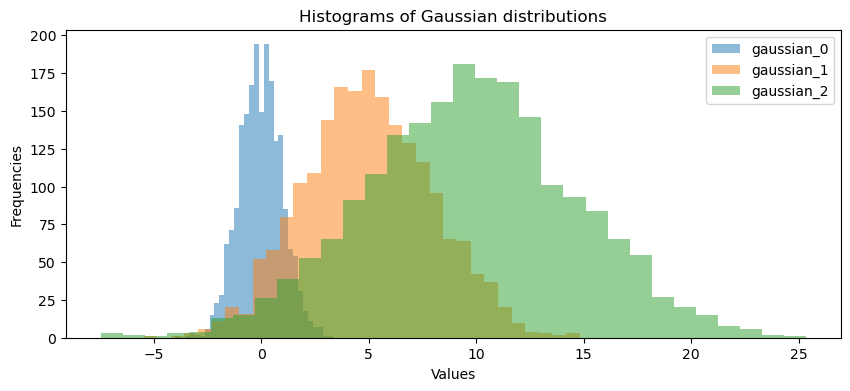

In [18]:
# 생성한 샘플이 정규분포를 따르는지 히스토그램을 그려서 확인 

gaussian_0 = gaussian_generator(0, 1, 2000)
gaussian_1 = gaussian_generator(5, 3, 2000)
gaussian_2 = gaussian_generator(10, 5, 2000)

plot_gaussian_distributions(gaussian_0, gaussian_1, gaussian_2)

### <span style="color:blue"> 1.4 이항분포를 따르는 랜덤 샘플 생성기</span>
 
- 이항분포를 따르는 랜덤 샘플을 생성하기 위해 필요한 것은 누적분포의 역함수 역할을 하는 함수를 준비하는 것입니다.  

### <span style="color:blue"> 1.4.1 이항분포: 누적분포함수의 일반화된 역함수(분위수 함수) </span>

$X \sim \text{B}(n,p)$이면 해당 PDF는 다음과 같습니다. $$P(X = k) = {n \choose k}p^{k}(1-p)^{n-k}.$$ 따라서 $0 \leq x \leq n$이면 CDF는 다음과 같이 계산됩니다. $$F(x) = P(X \leq x) = P(X = 0) + P(X = 1) + \ldots + P(X = \lfloor x \rfloor) = \sum_{k=0} ^{\lfloor x \rfloor} {n \choose k}p^{k}(1-p)^{n-k}.$$ 여기서 $\lfloor x \rfloor$는 $x$보다 작거나 같은 가장 큰 정수를 반환하는 [바닥 함수](https://en.wikipedia.org/wiki/Floor_and_ceiling_functions)를 나타냅니다. 예를 들어 $\lfloor 2.9 \rfloor = 2$ 및 $\lfloor 1.2 \rfloor = 1$입니다. $F$의 정의역은 실수의 전체 집합이지만 $P(X = k)$는 0과 $n$ 사이의 양의 정수 값에 대해서만 0이 아니기 때문에 이 함수가 필요합니다. $x > n$이면 $F(x) = 1$입니다. 


- 이항분포에 대해 CDF 함수 `cdf_binomial`과 일반화된 CDF의 역함수(분위수 함수) `inverse_cdf_binomial`을 직접 구현해 보겠습니다. 

>-  이항분포에 대한 CDF와 분위수 함수를 구현해 놓은 라이브러리의 예로는 이항분포를 클래스로 구현한 [scipy.stats.binom](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.binom.html)를 참조할 수 있습니다. 특히 CDF 함수는 `scipy.stats.binom.cdf`, 분위수 함수는 `scipy.stats.binom.ppf`와 같이 클래스 객체의 메소드로 정의되어 있습니다. 



- $\displaystyle{{n \choose k}= \dfrac{n!}{k!(n-k)!}}$를 `factorial` 함수를 이용하여 직접 만들어 쓸 수도 있지만, 넘파이 배열의 계산 장점을 살리기 위해 `scipy.specical`모듈에서 읽어들인 `comb` 함수를 사용합니다. 코드 실행 셀에서 `?comb`을 입력하여 사용법을 확인하세요. 

 >- `comb(N,k,exact=False)`와 같이 입력 인자 `exact`를 기본값 `False`로 전달하면, `N`과 `k`를 모두 배열로 전달할 수 있습니다. (이 경우, 계산은 부동 소수점 실수로 계산합니다. 
 
 >- 예를 보죠.

In [19]:
N = np.full((11,),10)
k = np.arange(11)
comb(N,k)

array([  1.,  10.,  45., 120., 210., 252., 210., 120.,  45.,  10.,   1.])

- 넘파이 배열의 연산(성분별 연산), 함수를 이용한 배열 생성을 이용해서 `cdf_binomial`을 구현해 보겠습니다. 
 >- 이 함수를 구현해보면, 이항분포를 클래스로 구현하고 CDF와 같은 함수를 메소드로 구현하는 것이 왜 필요한지 알게 됩니다. 
 $$ $$
 (아래 구현에서 CDF의 기준이 되는 `b_cdf`를 클래스의 속성으로 갖고 있고, 이 속성을 이용해서 메소드 CDF를 구현하는 것이 훨씬 효율적입니다.) 
 $$ $$
 >- 입력이 0차원 또는 1차원 배열인 경우에 대해서만 구현했습니다. 일반적인 차원의 배열에 대해 구현하려면 수정이 필요하겠죠.

In [20]:
def cdf_binomial(x, n, p):
    """
    Calculates the cumulative distribution function (CDF) F(x) of a binomial distribution.

    Parameters:
    - x (float or ndarray): x or array of x.
    - n (int): The number of trials in the binomial distribution.
    - p (float): The probability of success in each trial.

    Returns:
    - F(x) (float or ndarray): 
    """
    N = np.full((n+1,), n)
    k = np.arange(n+1)
    p_array = np.fromfunction(lambda i: p**i, (n+1, ))
    q_array = np.fromfunction(lambda i:(1-p)**(n-i), (n+1, ))
    
    # 기준이 되는 pdf 값 
    b_pdf = comb(N, k) * p_array * q_array
    
    # 기분이 되는 cdf 값
    b_cdf = np.cumsum(b_pdf)
    
    # 입력이 숫자인지 배열인지에 따라 결과를 반환
    if np.array(x).ndim == 0:
        return b_cdf[ int(np.floor(x)) ]
    else:
        # b_cdf의 index로 사용하기 위해 정수형으로 x_floor를 준비
        x_floor = np.zeros_like(x, dtype=int)
        x_floor[:] = np.floor(x)
        return b_cdf[x_floor]           # 정수 배열로 인덱싱

- 구현한 `cdf_binomial`의 입력 인자 `x`가 배열이면 성분별로 CDF가 계산된 배열이 반환됩니다. 

 >- 이 강의 첫 부분에서`scipy.stats`에서 `binom`을 읽어들였으니, `binom(n,p)`로 이항분포 객체를 만들고, `binom(n,p).cdf(x)`메소드를 이용해 비교해 보겠습니다. 

In [21]:
###### # 구현한 이항분포의 CDF 테스트 

print(f"Binomial distribution B({15},{0.9}): CDF F({3.8})= {cdf_binomial(3.8, 15, 0.9):.3f}")
print(f"Binomial distribution B({15},{0.5}): CDF F({10.9})= {cdf_binomial(10.9, 15, 0.5):.3f}")
print(f"Binomial distribution B({20},{0.2}): CDF F({18.4})= {cdf_binomial(18.4, 20, 0.2):.3f}")
print(f"Binomial distribution B({15},{0.5}): CDF F({6.4})= {cdf_binomial(6.5, 15, 0.5):.3f}")
print(f"\n{np.array2string(cdf_binomial([1.2, 3.5, 18.2], 20, 0.7), precision=3)}") # 배열에 대해서도 성분별로 CDF 값을 반환 


Binomial distribution B(15,0.9): CDF F(3.8)= 0.000
Binomial distribution B(15,0.5): CDF F(10.9)= 0.941
Binomial distribution B(20,0.2): CDF F(18.4)= 1.000
Binomial distribution B(15,0.5): CDF F(6.4)= 0.304

[1.662e-09 5.427e-07 9.924e-01]


In [22]:
###### # 내장함수 binom.cdf와 비교 

print(f"Binomial distribution B({15},{0.9}): CDF F({3.8})= {binom(15, 0.9).cdf(3.8):.3f}")
print(f"Binomial distribution B({15},{0.5}): CDF F({10.9})= {binom(15, 0.5).cdf(10.9):.3f}")
print(f"Binomial distribution B({20},{0.2}): CDF F({18.4})= {binom(20, 0.2).cdf(18.4):.3f}")
print(f"Binomial distribution B({15},{0.5}): CDF F({6.4})= {binom(15, 0.5).cdf(6.5):.3f}")
print(f"\n{np.array2string(binom(20,0.7).cdf([1.2, 3.5, 18.2]), precision=3)}") # 배열에 대해서도 성분별로 CDF 값을 반환 


Binomial distribution B(15,0.9): CDF F(3.8)= 0.000
Binomial distribution B(15,0.5): CDF F(10.9)= 0.941
Binomial distribution B(20,0.2): CDF F(18.4)= 1.000
Binomial distribution B(15,0.5): CDF F(6.4)= 0.304

[1.662e-09 5.427e-07 9.924e-01]


- 구현한 CDF 함수와 내장함수의 결과가 동일함을 확인할 수 있습니다. 

- 이제 일반화된 CDF의 역함수(분위수 함수) `inverse_cdf_binomial`을 구현하겠습니다. 
 >- 이번에도 입력이 0차원 또는 1차원 배열인 경우에 대해서만 구현했습니다. 일반적인 차원의 배열에 대해 구현하려면 수정이 필요하겠죠.

In [23]:
def inverse_cdf_binomial(y, n, p):
    """
    Calculates the inverse cumulative distribution function (CDF) of a binomial distribution.

    Parameters:
    - y (float or ndarray): The probability or array of probabilities.
    - n (int): The number of trials in the binomial distribution.
    - p (float): The probability of success in each trial.

    Returns:
    - x (float or ndarray): The corresponding value(s) from the binomial distribution that correspond to the given probability/ies.
    """
    
    # 이항분포 B(n,p)에 대해, [0,1,...,n]에 대응되는 CDF 값 배열 생성
    b_cdf = cdf_binomial(np.arange(n+1), n, p)
    
    if np.array(y).ndim ==0:   # y가 배열이 아닐 때
        return np.argmax(b_cdf >= y)  # F[n] >= y를 만족하는 n의 최솟값
    else:                      # y가 배열일 때
        results = np.zeros_like(y, dtype=int)
        for i in range(len(results)):   # index로 사용하려면 정수형이라야 함
            results[i] = np.argmax(b_cdf >= y[i])
        return results

- 구현한 분위수 함수 `inverse_cdf_binomial`과 `binom` 인스턴스의 `binom.ppf`의 실행 결과 비교

In [24]:
# 구현한 분위수 함수 테스트 
random_samples = np.random.random((20, ))

print(f"Inverse of Binomial CDF with n {15} and p {0.9} for value {1e-10}: {inverse_cdf_binomial(1e-10, 15, 0.9):.3f}")
print(f"Inverse of Binomial CDF with n {15} and p {0.5} for value {0}: {inverse_cdf_binomial(0, 15, 0.5)}")
print(f"Inverse of Binomial CDF with n {20} and p {0.2} for value {0.4}: {inverse_cdf_binomial(0.4, 20, 0.2):.3f}")
print(f"Inverse of Binomial CDF with n {15} and p {0.5} for value {1}: {inverse_cdf_binomial(1, 15, 0.5)}")
print(f"\n{np.array2string(inverse_cdf_binomial(random_samples, 40, 0.6))}")

Inverse of Binomial CDF with n 15 and p 0.9 for value 1e-10: 3.000
Inverse of Binomial CDF with n 15 and p 0.5 for value 0: 0
Inverse of Binomial CDF with n 20 and p 0.2 for value 0.4: 3.000
Inverse of Binomial CDF with n 15 and p 0.5 for value 1: 15

[18 25 22 28 24 22 24 23 25 20 32 23 23 26 23 27 24 26 20 27]


In [25]:
# binom.ppf 분위수 함수 테스트 

print(f"Inverse of Binomial CDF with n {15} and p {0.9} for value {1e-10}: {binom(15, 0.9).ppf(1e-10):.3f}")
print(f"Inverse of Binomial CDF with n {15} and p {0.5} for value {0}: {binom(15, 0.5).ppf(0)}")
print(f"Inverse of Binomial CDF with n {20} and p {0.2} for value {0.4}: {binom(20, 0.2).ppf(0.4):.3f}")
print(f"Inverse of Binomial CDF with n {15} and p {0.5} for value {1}: {binom(15, 0.5).ppf(1)}")
print(f"\n{np.array2string(binom(40,0.6).ppf(random_samples))}")

Inverse of Binomial CDF with n 15 and p 0.9 for value 1e-10: 3.000
Inverse of Binomial CDF with n 15 and p 0.5 for value 0: -1.0
Inverse of Binomial CDF with n 20 and p 0.2 for value 0.4: 3.000
Inverse of Binomial CDF with n 15 and p 0.5 for value 1: 15.0

[18. 25. 22. 28. 24. 22. 24. 23. 25. 20. 32. 23. 23. 26. 23. 27. 24. 26.
 20. 27.]


- 구현한 분위수 함수와 클래스 객체의 메소드로 정의되어 있는 함수의 실행 결과를 비교해보니, 오히려 `binom.ppf`의 결과에 문제점이 발견됩니다. 

 >- $F^{-1}(0)=0$이 되어야 하는데 구현한 함수 `inverse_cdf_binomial`의 결과 `0`과 달리 `binom.ppf`의 결과는 `-1.0`이 반환되었습니다.  
 
 >- 나머지 경우의 답은 모두 동일하게 나왔지만, `binom.ppf`의 반환값은 정수가 아닌 부동 소수점 실수로 반환되는 것도 차이가 있습니다. 

### <span style="color:blue">1.4.2 이항분포를 따르는 랜덤 샘플 생성</span>

- 이제 필요한 모든 준비가 끝났습니다. 이항분포 $\text{B}(n,p)$를 따르는 랜덤 샘플 생성기를 만들 수 있습니다.

>- 함수 이름을 `binomial_generator` 로 정하고 구현해보죠. 


In [26]:
def binomial_generator(n, p, num_samples):
    """
    Generates an array of binomially distributed random numbers.

    Args:
        n (int): The number of trials in the binomial distribution.
        p (float): The probability of success in each trial.
        num_samples (int): The number of samples to generate.

    Returns:
        array: An array of binomially distributed random numbers.
    """
    # `num_samples`개의 균등분포를 따르는 랜덤 샘플 생성
    u = uniform_generator(0, 1, num_samples)
    
    # 분위수 함수를 이용하여 이항분포를 따르는 랜덤 샘플 생성
    array = inverse_cdf_binomial(u, n, p)
    return array

- `binomial_generator`로 생성한 랜덤 샘플이 이항분포를 따르는지 히스토그램을 그려 확인해보죠. 

 >- 아래 셀의 `binomial_0` 샘플은 평균이 $4.8$, `binomial_1` 샘플은 평균이 $7.5$, `binomail_2` 샘플은 평균이 $20$인 이항분포에서 각각 생성한 샘플입니다. 

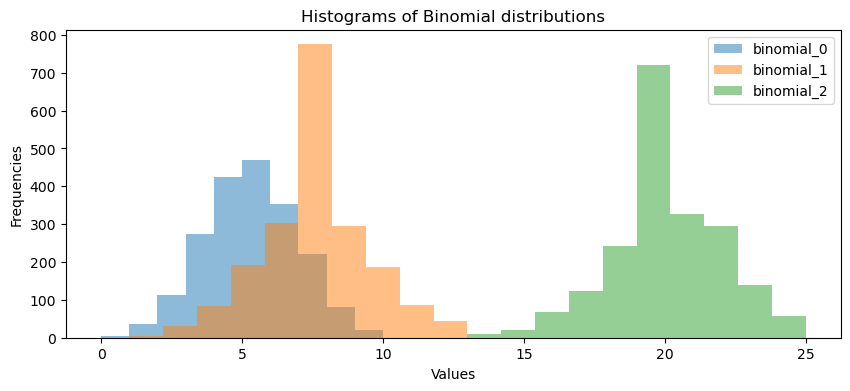

In [27]:
# 유틸리티 함수로 작성해 둔 `plot_binomial_distributions` 이용

binomial_0 = binomial_generator(12, 0.4, 2000)
binomial_1 = binomial_generator(15, 0.5, 2000)
binomial_2 = binomial_generator(25, 0.8, 2000)

plot_binomial_distributions(binomial_0, binomial_1, binomial_2)

## <span style="color:blue"> 2. 나이브 베이즈를 이용한 개 품종 분류기 만들기</span>

이번에는 앞서 구현한 랜덤 샘플 생성기들을 활용하여 세 가지 종류의 개 품종에 대한 정보가 포함된 데이터 세트를 인위적으로 만들어 보겠습니다.  데이터 세트를 준비한 후에는, 개들의 특징을 기준으로 개를 정확하게 분류하는 나이브 베이즈(Naive Bayes) 분류기를 만들어 보도록 하겠습니다. 

### <span style='color:blue'> 2.1. 데이터 세트 생성하기 </span>
    
- 각각의 개에 대해 네 가지 특징으로 구성된 데이터 세트를 생성합니다. 

 >- 개의 키 'height'(센티미터): 정규분포를 따르는 것으로 생각할 수 있습니다.  
 
 >- 개의 무게 'weight'(킬로그램): 정규분포를 따르는 것으로 생각할 수 있습니다. 
 
 >- 30일 중 개가 짖는 날의 수 'bark_days': 이는 'n = 30'인 이항 분포를 따르는 것으로 생각하겠습니다. 
 
 >- 귀 길이와 머리 길이의 비율 `ear_head_ratio`: 균등분포를 따르는 것으로 생각할 수 있겠죠.  
 
- 앞서 구현한 여러 분포의 랜덤 샘플 생성기 함수를 사용해서, 개 품종 분류 문제에 사용할 다양한 합성 데이터를 생성해 보겠습니다. 

In [28]:
FEATURES = ["height", "weight", "bark_days", "ear_head_ratio"]

### <span style='color:blue'> 2.1.1 @dataclass 사용하기 </span>

이 강의를 시작할 때 `from dataclasses import dataclass`와 같이 `dastaclass`를 읽어들였기 때문에 
@dataclass 데코레이터를 사용할 수 있습니다. 

- 일반 클래스에  @dataclass 데코레이터를 선언해주면 해당 클래스는 소위 데이터 클래스가 됩니다. (데이터 클래스는 점 표기법을 사용하여 각 변수에 접근할 수 있는 데이터 컨테이너 정도로 생각하면 됩니다.)

- `일반 클래스`를 정의하면, 클래스 필드에 해당하는 변수를 반복해서 입력해야 하는 등 다음과 같은 번거로운 작업을 해야 합니다.  

 >- `__init__()`을 작성해야 합니다. 
 
 >- 출력할 때 필드명이 보이도록 하려면 `__repr__()`도 적절하게 작성해야 합니다.   

 >- 또, 동일한 필드값으로 생성한 두 개의 인스턴스를 `==`로 비교할 때 `True`가 되도록 하려면 `__eq__()`도 적절하게 정의해야 합니다.  

- 데이터 클래스는 파이썬 3.7 버전부터 추가된 것으로  `__init__()`, `__repr__()`, `__eq__()`와 같은 메소드를 모두 자동으로 생성해주는 장점이 있습니다. 
$$ $$

우선 간단히 사용하는 방법을 예를 통해 확인해보죠.

In [29]:
@dataclass

class student:
    name: str
    age: int
    id: str
    
student1 = student(name="도하나", age=25, id="a12345")
student2 = student(name="라미도", age=32, id="b12345")
student3 = student(name="도하나", age=25, id="a12345")

In [30]:
print(student1 == student2)     
print(student1 == student3)          # __eq__()가 자동으로 만들어졌음
student1                             # __rep__()가 자동으로 만들어졌음 

False
True


student(name='도하나', age=25, id='a12345')

In [31]:
student1.name, type(student1.age)    # 점 표기법으로 필드에 접근 

('도하나', int)

In [32]:
student1.age = 30
student1

student(name='도하나', age=30, id='a12345')

### <span style='color:blue'> 2.1.2 @dataclass 사용하여 합성 데이터 생성하기 </span>

지금부터 각기 다른 확률분포를 활용하여 개의 네 가지 특성을 생성할텐데, 확률분포를 결정하는 파라미터들이 효율적으로 다루기 위해 데이터 클래스를 사용하려고 합니다.

- 아래의 각 데이터 클래스에 `__repr__()`을 별도로 정의하지 않아도 자동으로 생성되지만, 부동 소수점 실수의 자릿수를 조절해서 출력하기 위해 새로 정의합니다. 

In [33]:
@dataclass
class params_gaussian:
    mu: float
    sigma: float
        
    def __repr__(self):
        return f"params_gaussian(mu={self.mu:.3f}, sigma={self.sigma:.3f})"


@dataclass
class params_binomial:
    n: int
    p: float
        
    def __repr__(self):
        return f"params_binomial(n={self.n:.3f}, p={self.p:.3f})"


@dataclass
class params_uniform:
    a: int
    b: int
        
    def __repr__(self):
        return f"params_uniform(a={self.a:.3f}, b={self.b:.3f})"

- 이제 다양한 확률분포에 대한 파라미터 정보를 데이터 클래스로 저장할 수 있으므로, 모든 개 품종에 대한 정보를 파이썬의 딕셔너리 자료형으로 저장할 수 있습니다. 

In [34]:
breed_params = {
    0: {
        "height": params_gaussian(mu=35, sigma=1.5),
        "weight": params_gaussian(mu=20, sigma=1),
        "bark_days": params_binomial(n=30, p=0.8),
        "ear_head_ratio": params_uniform(a=0.6, b=0.1)
    },
    
    1: {
        "height": params_gaussian(mu=30, sigma=2),
        "weight": params_gaussian(mu=25, sigma=5),
        "bark_days": params_binomial(n=30, p=0.5),
        "ear_head_ratio": params_uniform(a=0.2, b=0.5)
    },
    
    2: {
        "height": params_gaussian(mu=40, sigma=3.5),
        "weight": params_gaussian(mu=32, sigma=3),
        "bark_days": params_binomial(n=30, p=0.3),
        "ear_head_ratio": params_uniform(a=0.1, b=0.3)
    }
    
}

- 이제, `breed_params`에 정의된 각 품종에 대한 분포와 그 파라미터를 사용하여 데이터 세트를 생성할 차례입니다.  

- 이 목적을 위해 `generate_data_for_breed`를 작성하는데, Python 3.10에 도입된 `match 문`을 사용하면 쉽고 명확하게 작성할 수 있습니다.

>- `match 문`을 사용하는 방법은 [링크](https://docs.python.org/release/3.11.0/tutorial/controlflow.html?highlight=match#match-statements)를 눌러 확인해보세요.  

> 이 함수는 합성한 데이터를 `pandas.DataFrame`으로 반환합니다. (`pandas`의 데이터 구조에 대해 기억이 나지 않는다면 10분만 투자하여 다음 [링크](https://pandas.pydata.org/docs/user_guide/10min.html#min) 내용을 확인하세요. Chrome의 자동 번역 기능을 사용하면 영어가 서툴러도 내용 파악에 문제가 없습니다.)

In [35]:
def generate_data_for_breed(breed, features, n_samples, params):
    """
    Generate synthetic data for a specific breed of dogs based on given features and parameters.

    Parameters:
        - breed (str): The breed of the dog for which data is generated.
        - features (list[str]): List of features to generate data for (e.g., "height", "weight", "bark_days", "ear_head_ratio").
        - n_samples (int): Number of samples to generate for each feature.
        - params (dict): Dictionary containing parameters for each breed and its features.

    Returns:
        - df (pandas.DataFrame): A DataFrame containing the generated synthetic data.
            The DataFrame will have columns for each feature and an additional column for the breed.
    """
    
    df = pd.DataFrame()
    
    for feature in features:
        match feature:
            case "height" | "weight":
                df[feature] = gaussian_generator(params[breed][feature].mu, params[breed][feature].sigma, n_samples)
                
            case "bark_days":
                df[feature] = binomial_generator(params[breed][feature].n, params[breed][feature].p, n_samples)
                                       
            case "ear_head_ratio":
                df[feature] = uniform_generator(params[breed][feature].a, params[breed][feature].b, n_samples)    
    
    df["breed"] = breed
    
    return df

- 이제, `generate_data_for_breed`함수를 이용하여 개 품종별로 합성한 데이터를 DataFrame 형태로 저장합니다.

In [36]:
# 개 품종(0,1,2)별로 합성 데이터 생성 
df_0 = generate_data_for_breed(breed=0, features=FEATURES, n_samples=1200, params=breed_params)
df_1 = generate_data_for_breed(breed=1, features=FEATURES, n_samples=1350, params=breed_params)
df_2 = generate_data_for_breed(breed=2, features=FEATURES, n_samples=900, params=breed_params)

# 품종 별 데이터를 하나의 DataFrame으로 합침
df_all_breeds = pd.concat([df_0, df_1, df_2]).reset_index(drop=True)

# 품종 별로 나열된 데이터를 섞어 줍니다. 
df_all_breeds = df_all_breeds.sample(frac = 1)

# 처음 열 개의 데이터를 확인합니다. 
df_all_breeds.head(10)

,height,weight,bark_days,ear_head_ratio,breed
1409,28.285935,14.064465,13,0.478512,1
3330,40.107300,34.629050,10,0.108720,2
2555,39.207571,35.418181,10,0.178952,2
524,36.251996,19.073590,24,0.323122,0
231,32.891536,19.285846,24,0.381263,0
184,38.665057,19.309999,27,0.378051,0
1902,30.720614,33.299969,16,0.322841,1
453,33.686888,19.522597,25,0.200519,0
371,34.256232,20.058232,23,0.528556,0
550,33.169874,21.166116,25,0.504923,0


- 이제 이 데이터 세트의 각 행은 어떤 개의 특성을 나타내는 특성 벡터(1열 `height`부터 4열 `ear_head_ratio`까지)와 개 품종(5열 `breed`)에 대한 정보입니다. 이미 생성한 데이터 세트를 랜덤하게 섞었으므로 70% 정도는 학습용 데이터, 나머지 30% 정도는 테스트용 데이터로 나누도록 하겠습니다. 

- 학습용 데이터만을 이용해서 나이브 베이즈 분류기를 학습시키고, 데이터의 특성 벡터를 이용하여 학습시킨 나이브 베이즈 분류기가 개 품종을 정확하게 예측하는지 테스트 데이터 세트를 이용해서 확인해 보도록 하겠습니다.  

>- 나이브 베이즈 분류기에 대해서는 곧 설명하도록 하죠. 

In [37]:
# 데이터 세트 나누기 (0.7:0.3)
split = int(len(df_all_breeds)*0.7)  # 70% 기준이 되는 index

# 학습용 데이터와 테스트용 데이터로 나누기 
df_train = df_all_breeds[:split].reset_index(drop=True)
df_test = df_all_breeds[split:].reset_index(drop=True)

## <span style='color:blue'>2.2. 나이브 베이즈 분류기 </span>

### <span style='color:blue'>2.2.1 베이즈 정리와 조건부 독립 </span>
**우선 필요한 통계학 지식을 간략히 설명하겠습니다.**

사건 $A_1,\cdots,A_n$이 주어질 때, 확률 $\mathbf P(A_1\cap \cdots \cap A_n)$을 보통 $\mathbf P(A_1\cdots A_n)$처럼 간단하게 나타냅니다. 이때, 조건부 확률 (베이즈 정리)

$$\mathbf P(A|B)=\dfrac{\mathbf P(A\cap B)}{\mathbf P(B)}\Longleftrightarrow \mathbf P(A\cap B)=\mathbf P(B)\mathbf P(A|B)
\Longleftrightarrow \mathbf P(A\cap B)=\mathbf P(A)\mathbf P(B|A)$$

를 반복하여 적용하면 

$$\mathbf P(A_1\cdots A_n)=\mathbf P(A_1)\,\mathbf P(A_2|A_1)\,\mathbf P(A_3|A_1A_2)\,\cdots\, \mathbf P(A_n|A_1\cdots A_{n-1}) \qquad \qquad (1)
$$

이 성립하고, 이로부터 사건 $C$에 대해 

$$\mathbf P(A_1\cdots A_n|C)=\mathbf P(A_1|C)\,\mathbf P(A_2|CA_1)\,\mathbf P(A_3|CA_1A_2)\, \cdots\, \mathbf P(A_n|CA_1\cdots A_{n-1}) \qquad \qquad (2)
$$
도 성립합니다. 

사건 $C$가 주어질 때 각 사건 $A_i$가 일어날 조건부 확률 $\mathbf P(A_i|C)$이 $C$이외의 다른 사건에는 영향을 받지 않을 때, 즉

$$\mathbf P(A_i|C)=\mathbf P(A_i|C A_1) = P(A_i|C A_1 A_2) = \cdots $$

일 때, 사건 $A_1,\cdots, A_n$은 **조건부 독립**이라고 합니다. 이때, 위의 식 (2)는 

$$\mathbf P(A_1\cdots A_n|C)=\mathbf P(A_1|C)\,\mathbf P(A_2|C)\, \mathbf P(A_3|C)\, \cdots \, \mathbf P(A_n|C)
= \prod_{i=1}^n \mathbf P(A_i|C)\qquad \qquad (3)
$$

이 됩니다.  

- 일반적으로 주어진 사건들이 특정 사건에 대해 조건부 독립이 된다는 것을 100% 보장하지 못하더라도, 이런 가정이 어느 정도 가능한 상황이면 모델링을 단순화시키기 위해 적용하는 경우가 있습니다. 
$$ $$
(베이즈 정리로부터 얻은 식 (1)에 조건부 독립이 성립한다고 가정하고 식 (3)을 얻었는데, 뒤에 만들 분류기는 조건부 독립이 성립한다고 가정하는 것이 큰 무리가 없다고 낙관적으로 생각하고 식 (3)을 이용하여 분류기를 만든다는 의미에서 나이브 베이즈 분류기라고 부릅니다.)   

 >- 예를 들어, 개 품종이 정해질 때, 앞서 데이터를 생성할 때 적용했던 것처럼 `귀와 머리 비율`, `체중`, `키`는 각각 어떤 균등분포, 정규분포를 따르는 확률변수로 생각할 수 있고, 조건부 독립이라고 가정해도 큰 무리가 없습니다. 


또, 각각의 확률변수 $X_i\ (1\le i \le n)$가 특정 확률분포를 따를 때, 확률변수 $X_i$가 특정 범위의 값을 취하는 사건을 $A_i$라고 하면, 위의 식 (1)과 (2)로부터 결합 확률밀도(질량)함수, 주변 확률밀도함수, 조건부 확률밀도함수에 대한 식으로 표현하는 것이 가능합니다.
 


또, 확률변수 $X_i$들이 확률변수 $Y=y$에 대해 조건부 독립이라는 것은, $Y=y$라는 조건하에서 $X_i$에 관한 임의의 사건 $A_i$가 조건부 독립이라는 뜻입니다. 이때 식 (2)와 (3)을 확률밀도(질량)함수에 대해 쓰면 

$$
f_{X_1,\cdots,X_n|Y}(x_1,\cdots,x_n|y)=f_{X_1|Y}(x_1|y)\, f_{X_2|X_1,Y}(x_2|x_1,y)\, \cdots\, f_{X_n|X_1,\cdots,X_{n-1},Y}(x_n|x_1,\cdots,x_{n-1},y)\qquad \qquad (2')
$$

$$
f_{X_1,\cdots,X_n|Y}(x_1,\cdots,x_n|y)=f_{X_1|Y}(x_1|y)\, f_{X_2|Y}(x_2|y)\, \cdots\, f_{X_n|Y}(x_n|y)
=\prod_{i=1}^n f_{X_i|Y}(x_i|y)\qquad \qquad (3')
$$

이 됩니다. 

---
<span style='color:orange'>확률밀도함수 표현법</span>

편의상 고려하는 확률변수에 관계없이 확률밀도함수를 동일하게 $f$로 쓰고 첨자를 통해 어떤 확률밀도함수인지를 나타냅니다. 위 식에서
$Y=y$가 주어질 때 확률변수 $X_1=x_1,\cdots,X_n=x_n$에 대한  확률밀도함수의 값을 $f_{X_1,\cdots,X_n|Y}(x_1,\cdot,x_n|y)$로 나타냈는데, 정확한 의미는 $X_1,\cdots,X_n,Y$의 결합확률밀도함수 $f_{X_1,\cdots,X_n,Y}$와 $Y$의 확률밀도함수 $f_Y$에 대해 
$$
f_{X_1,\cdots,X_n|Y}(x_1,\cdot,x_n|y)= \dfrac{f_{X_1,\cdots,X_n,Y}(x_1,\cdots,x_n,y)}{f_{Y}(y)}
$$
라는 의미입니다. 예를 들어, 
$$f_{X_i|Y}(x_i|y)=\dfrac{f_{X_i,Y}(x_i,y)}{f_Y(y)},\qquad 
f_{X_i|X_j,X_k,Y}(x_i|x_j,x_k,y)=\dfrac{f_{X_i,X_j,X_k,Y}(x_i,x_j,x_k,y)}{f_{X_j,X_k,Y}(x_j,x_k,y)}$$
입니다.

또 확률변수 $X_1,\cdots,X_n$에 대한 (결합)확률밀도함수 $f_{X_1,\cdots,X_n}$이 있을 때, $X_i$에 대한 (주변)확률밀도함수는 
$f_{X_1,\cdots,X_n}(x_1,\cdots,x_n)$에서 $x_i$변수를 제외한 나머지 모든 변수에 대해 적분(또는 합)하여 구할 수 있습니다. 예를 들어,
$$
f_{X_1}(x_1)=\int_{-\infty}^{\infty}\cdots \int_{-\infty}^{\infty} f_{X_1,\cdots,X_n}(x_1,\cdots,x_n)\,dx_2dx_3\cdots dx_n
$$
---

### <span style='color:blue'>2.2.2 나이브 베이즈 분류기 설명</span>

지금부터 나이브 베이즈 분류기가 무엇인지 설명해 보겠습니다.   

- $\mathcal X$를 훈련 데이터 세트로 둡니다. $\mathbf x \in \mathcal X$는 $\mathbf x = (x_1, x_2, \ldots, x_n)$형태의 벡터입니다. 여기서 $n$은 각 샘플의 특성 수입니다. 예를 들어, $\mathcal X$는 100개의 개 품종 데이터 세트일 수 있으며, 각 개 품종은 귀 머리 비율(ear_head_ratio), 체중(weight), 키(height)와 같은 3가지 특성을 가진다고 가정하죠. 따라서 $X = \{ \text{dog}_1, \text{dog}_2, \ldots, \text{dog}_{100} \}$이고 각 개 품종, 예를 들어 $\text{dog}_5$는 다음과 같이 3차원 벡터로 표현됩니다.  $\text{dog}_5 = (\text{ear_head_ratio}_{\text{dog}_5}, \text{weight}_{\text{dog}_5}, \text{height}_{\text{dog}_5})$. 


- 이제 분류하고 싶은 $m$개의 범주 $C_1, C_2, \ldots, C_m$가 있다고 가정합니다. 예를 들어, 개 품종의 특성 벡터들로 이루어진 훈련 데이터에 $m = 5$가지 유형의 개 품종이 있다고 가정하는 상황입니다. 우리 구성하려고 하는 분류기의 아이디어는 각 샘플의 특성을 보고 샘플 $\mathbf x=(x_1,\cdots,x_n) \in \mathcal X$의 범주(유형)를 다음과 같이 예측하는 것입니다. 
$$ $$
즉, 범주를 결정하는 각 $i=1,\cdots,m$에 대해 
$$ $$
$$\mathbf P(C_i|\mathbf x)=\dfrac{\mathbf P(C_i\cap \mathbf x)}{\mathbf P(\mathbf x)}= \dfrac{\mathbf P(C_i)\mathbf P(\mathbf x|C_i)}{\mathbf P(\mathbf x)}  \qquad \qquad (4)
$$
$$ $$
를 계산하고, <span style='color:orange'>이 중 가장 큰 값이 나온 $i$를 샘플 벡터의 유형으로 예측하는 것</span>입니다. 이 방법으로 구성한 범주 분류기를 <span style='color:orange'>베이즈 분류기</span>라고 부릅니다. 
$$ $$
다시 말해, 베이즈 분류기는 $\mathbf x$에 대해 
$$\text{argmax}_i\{\mathbf P(C_i|\mathbf x)|i=1,\cdots,m\}\qquad \qquad (5)$$
를 반환하는 분류기입니다. 

>- 이때 중요한 점은 식 (5)를 비교하기 위해서 각 $i=1,\cdots,m$에 대해 식 (4)를 계산할 때, $\mathbf P(\mathbf x)$는 고정되어 있으므로 $\mathbf P(C_i)\mathbf P(\mathbf x|C_i)$만 구해서 비교하면 된다는 점입니다. 특히, 모든 $\mathbf P(C_i)$ 값이 $1/m$로 일정한 경우에는 $\mathbf P(\mathbf x|C_i)$만 비교하면 됩니다. 즉, 분류기는 다음과 같이 구성할 수 있습니다.
$$ $$
$$\text{argmax}_i\{\mathbf P(C_i)\mathbf P(\mathbf x|C_i)|i=1,\cdots,m\}\qquad \qquad (5')$$


>- 또, 식 $(5')$에서 $\mathbf P(\mathbf x|C_i)$를 계산할 때 각 특성 $X_k$가 이산확률변수인 경우에는 특정값을 가질 확률이 확률밀도함수의 값과 같지만, 연속확률변수일 때는 특정값을 가질 확률이 $0$입니다. 
$$ $$
<span style='color:orange'>하지만, 우리에게 필요한 정보는 서로 다른 $i$에 대해 $\mathbf P(\mathbf x|C_i)$를 비교하는 것이고, 동일한 $\mathbf x$에 대해 비교하는 상황이므로 $C_i$ 범주에 대한 확률밀도함수 
    $$f_{X_1,\cdots,X_n|C}(x_1,\cdots,x_n|C_i)$$
$$ $$
로 바꾸어 비교할 수 있습니다.(특정 벡터 $\mathbf x$의 주변에 속할 확률을 근사적으로 사용한다고 생각하면 이해하기 쉽습니다.) </span>
즉, 분류기는 다음과 같이 구성할 수 있습니다. 
$$ $$
$$\text{argmax}_i\{ f_C(C_i)f_{X_1,\cdots,X_n|C}(x_1,\cdots,x_n|C_i)\,|\,i=1,\cdots,m\}\qquad \qquad (5'')$$
$$ $$


- 우리가 개 품종 특성 데이터를 생성할 때, 각각의 특성이 어떤 확률분포를 따른다고 생각했었죠. 이처럼 개가 어떤 품종인지를 나타내는 확률변수를 $C$, 각 특성도 확률변수 $X_1,\cdots, X_n$이라고 생각할 수 있습니다. 이제, 특정 품종 $C=C_i$라는 조건하에서 각 특성 $X_i$가 특정값 $x_i$를 가질 확률밀도(질량)함수의 값을 구하려면 식 $(2')$을 이용하여 $f_{X_1,\cdots,X_n|C}(x_1,\cdots,x_n|C_i)$를 구해야 하므로 계산이 복잡합니다. 

>- 여기서 나이브 베이즈 정리가 사용됩니다. 일반적으로 각 $\mathbf x$ 및 각 범주에 대해 $\mathbf P(\mathbf x \mid C_i)$ 또는 $f_{X_1,\cdots,X_n|C}(x_1,\cdots,x_n|C_i)$를 계산하는 것은 앞서 설명한 것처럼 식$(2)$ 또는 $(2')$을 이용해야 하므로 계산량이 많습니다. 하지만,  각 특성이 각 범주(품종) 내의 다른 특성과 독립적이라는 것(즉, 조건부 독립)을 가정하면 식 $(3)$또는 $(3')$을 이용하면 되므로 간단해집니다.   

>- 예를 들어, 개 품종의 예에서  특정 유형의 개 품종에 대해 체중, 키, 귀  머리 비율 사이에 상관 관계가 없음을 의미합니다. $\mathcal X$의 $\mathbf x = (x_1, \ldots x_n)$에 대해 범주별 조건부 독립을 가정하면 <span style='color:orange'>나이브 베이즈 분류기</span>은 식 $(5'')$에서 $f_{X_1,\cdots,X_n|C}(x_1,\cdots,x_n|C_i)$를 식 $(3')$으로 대체하여 
$$ $$
$$\text{argmax}_i\{ f_C(C_i)\prod_{k=1}^n f_{X_k|C}(x_i|C_i)\,|\,i=1,\cdots,m\}\qquad \qquad (6)$$
$$ $$
으로 구성할 수 있습니다. 

>- 이때, 확률밀도(질량)함수 $f_{X_i|C}(x_i|C_i)$는 $C=C_i$ 품종의 개일 때, 각 특성이 어떤 분포를 따르는지를 학습 데이터로부터 추정하게 되는 이를 `기계학습(Machine learning)`에서 학습한다고 부르는 과정입니다. 대표적인 확률분포를 가정할 때, 주어진 학습 데이터로부터 분포의 파라미터를 추정하여 확률밀도(질량)함수를 구하는 방법에 대해 공부하면 나이브 베이즈 분류기를 구현할 수 있습니다. 

### <span style='color:blue'>2.2.3 학습 데이터로부터 확률분포의 파라미터를 추정하는 방법</span>
### <span style='color:blue'>(나이브 베이즈 분류기 학습 방법)</span>

- 식 (6)의 나이브 베이즈 분류기를 구성하기 위해서, 학습 데이터로부터 각 확률분포의 파라미터를 결정하는 방법에 대해 알아보자. 

- 우선 각 품종 $C=C_i$를 고정할 때, 각 확률변수 $X_k$는 각각 어떤 확률분포를 따른다고 가정한다.  

>- 개의 품종에 대한 분류기의 경우를 생각하면, 각 품종 $C_i$마다 키와 체중에 대응되는 확률변수는 평균 $\mu_{C_i}$, 표준편차 $\sigma_{C_i}$인 정규분포를 따르고, 귀 머리 비율은 어떤 구간 $[a_{C_i},b_{C_i}]$에 대한 균등분포를 따른다고 가정한다. 이때, $\mu_{C_i},\sigma_{C_i}$는 정규분포에 대한 파라미터이고, $a_{C_i},b_{C_i}$는 균등분포에 대한 파라미터이다. 

>- 위 설명의 예에서는 다루지 않았지만, 우리가 인위적으로 생성해 놓은 특성 벡터에는 한 달 동안 짖는 횟수에 대응하는 확률변수도 있으며, 이 확률변수는 $\text{B}(30,p_{C_i})$인 이항분포를 따르는 것으로 생각할 수 있다. 

- 이제 학습 데이터를 이용하여 가정한 확률분포의 파라미터를 구하는 방법은 각 확률변수 별로 학습 데이터 샘플로 주어진 값들이 나올 확률이 가장 커지는 파라미터를 구하는 것입니다. 예를 들어, 학습 데이터에 $N$개의 특성 벡터가 주어졌다면 정규분포를 따르는 확률변수 $X_1$에 대응되는 $N$개의 독립적인 $x_1$ 값이 $x_1^{(1)},\cdots, x_1^{(N)}$으로 주어졌다는 말이고, 가정한 정규분포의 미지의 파라미터 $\mu_{C_i},\sigma_{C_i}$에 대한 정규분포의 확률밀도함수를 $f=f_{X_1|C_i}$라 하면 독립성으로부터 그 확률이 최대가 되게 하는 파라미터는  
$$\prod_{i=1}^{N}f\bigl(x_1^{(i)}\bigr)\qquad \qquad (7)$$
이 최대가 되게하는 $\mu_{C_i}$와 $\sigma_{C_i}$를 구하는 것으로 생각할 수 있습니다. 이 방법을 <span style='color:orange'>최대 우도추정법</span>이라고 합니다. 

>- 범주 $C_i$의 확률변수 $X$가 평균이 $\mu_i$이고 표준편차가 $\sigma_i$인 정규분포를 따른다면(즉, 평균과 표준편차가 범주에 따라 달라지는 경우) 확률밀도함수 $f_{X|C}(x|C_i)$는 
$$
f_{X|C}(x|C_i)=\dfrac{1}{\sqrt{2\pi}\sigma_i} \text{exp}\left(-\dfrac{(x-\mu_i)^2}{2\sigma_i^2}\right)
$$
인데, $x$에 $x_1^{(i)}$를 대입하고 곱한 식 (7)은 미지수 $\mu_i$, $\sigma_i$에 관한 함수가 되므로 이 함수가 최대가 되는 미지수를 구하면 됩니다. (로그를 취한 식이 최대가 되는 것을 구해도 되며, 미적분을 이용하면  각 편도함수가 $0$이라는 방정식을 풀어서 $\mu_i,\sigma_i$를 구할 수 있습니다.) 이때, 답은 다음과 같습니다.
$$\mu_i = \dfrac{\sum_{i=1}^{N}x_1^{(i)}}{N},\qquad \sigma_i^2 = \dfrac{\sum_{i=1}^N (x_1^{(i)}-\mu_i)^2}{N}$$

- 이항분포와 균등분포의 경우에도 최대우도 추정법을 이용하여 파라미터를 추정할 수 있습니다. (좀 더 자세한 내용은 통계학 교재를 참고하세요.)

- 이 강의에서는 개 품종 분류기에 대해, 최대우도추정법으로 파라미터를 추정하는 함수를 각 확률분포별로 작성해 두었습니다. 


### <span style='color:blue'>2.2.4 학습 데이터로부터 확률분포의 파라미터를 추정하는 함수 작성</span>

- 개 품종 분류기에 대한 특성별 확률분포 파라미터 추정 

>- `height`: 정규분포 파라미터 `mu` 및 `sigma` 추정
>- `weight`: 정규분포 파라미터 `mu` 및 `sigma` 추정
>- `bark_days`: 이항분포 파라미터 `p` 추정 (`n=30`은 고정된 상황) 
>- `ear_head_ratio`: 균등분포 파라미터 `a` 및 `b`추정 

- 위 상황에서 대응되는 확률분포의 파라미터를 추정하기 위해 다음 함수를 작성 

>- 학습 데이터로부터 정규분포의 파라미터를 추정하는 함수 `estimate_gaussian_params` : 주어진 샘플에 대한 표준편차를 `np.std`를 이용하여 구현(주의할 점은 입력인자 `ddof`의 기본설정값 `0`일 때는 샘플의 개수로 나누지만, 표본에 대한 표준편차를 구할 때는 `ddof=1`로 설정해야 합니다.) 

>- 학습 데이터로부터 이항분포의 파라미터를 추정하는 함수 `estimate_binomial_params`

>- 학습 데이터로부터 균등분포의 파라미터를 추정하는 함수 `estimate_uniform_params`

In [38]:
# 확률분포의 파라미터를 추정하는 함수들

def estimate_gaussian_params(sample):
    mu = np.mean(sample)
    sigma = np.std(sample)
    return mu, sigma


def estimate_binomial_params(sample):  
    n = 30
    p = (sample / n).mean()
    return n, p


def estimate_uniform_params(sample):
    a = sample.min()
    b = sample.max()
    return a, b

In [39]:
# 파라미터 추정 연습 
m, s = estimate_gaussian_params(np.array([26.31, 32.45, 14.99]))
print(f"Gaussian:\nmu = {m:.3f} and sigma = {s:.3f} for sample: {np.array([26.31, 32.45, 14.99])}\n")

n, p = estimate_binomial_params(np.array([9, 26, 18, 14, 5]))
print(f"Binomial:\nn = {n} and p = {p:.3f} for sample: {np.array([9, 26, 18, 14, 5])}\n")

a, b = estimate_uniform_params(np.array([0.9, 0.26, 0.18, 0.07, 0.5]))
print(f"Uniform:\na = {a:.3f} and b = {b:.3f} for sample: {np.array([0.9, 0.26, 0.18, 0.07, 0.5])}")

Gaussian:
mu = 24.583 and sigma = 7.232 for sample: [26.31 32.45 14.99]

Binomial:
n = 30 and p = 0.480 for sample: [ 9 26 18 14  5]

Uniform:
a = 0.070 and b = 0.900 for sample: [0.9  0.26 0.18 0.07 0.5 ]


### <span style='color:blue'>2.2.5 확률밀도(질량)함수 구현</span>

- 이제 식 (6)을 이용하여 나이브 베이즈 분류기를 구현하려면 각 확률분포에 대한 확률밀도(질량)함수를 구현해야 합니다. 

>- 아래 셀에서 작성하는 것처럼 직접 구현해도 되고, `scipy.stats` 모듈의 클래스를 이용하여 해당 확률분포 객체를 생성하고 해당 객체의`pdf` 메서드를 사용하도 됩니다.

>- `scipy.stats` 모듈에 대해 좀 더 알고 싶으면 다음 링크 [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html) 를 참조하세요.

- 각 확률분포에 대응되는 확률밀도(질량)함수를 정리하면 다음과 같습니다. 

>- $X \sim \text{Uniform}(a,b)$일 때, 확률밀도함수 $f_X$
$$f_X(x) = 
\begin{cases}
\frac{1}{b-a}, \quad \text{if } x \in [a,b]. \\
0, \quad \text{otherwise.}
\end{cases}
$$

>- $X \sim \text{N}(\mu,\sigma^2)$일 때, 확률밀도함수 $f_X$
$$f_X(x) = \frac{1}{\sigma \sqrt{2 \pi}} e^{-\frac{1}{2}\left(\frac{x - \mu}{\sigma}\right)^2}$$ 

>- $X \sim \text{B}(n,p)$일 때, 확률질량함수 $p_X$
$$p_X(x) = {n \choose x}  p^x  (1-p)^{n-x},\quad x=1,2,\ldots, n$$

In [40]:
# 확률밀도(질량)함수 구현 

def pdf_uniform(x, a, b):
    """
    Calculates the probability density function (PDF) for a uniform distribution between 'a' and 'b' at a given point 'x'.

    Args:
        x (float): The value at which the PDF is evaluated.
        a (float): The lower bound of the uniform distribution.
        b (float): The upper bound of the uniform distribution.

    Returns:
        float: The PDF value at the given point 'x'. Returns 0 if 'x' is outside the range [a, b].
    """
    pdf = 1 / (b - a) if (x >= a and x<= b) else 0 
    return pdf

def pdf_gaussian(x, mu, sigma):
    """
    Calculate the probability density function (PDF) of a Gaussian distribution at a given value.

    Args:
        x (float or array-like): The value(s) at which to evaluate the PDF.
        mu (float): The mean of the Gaussian distribution.
        sigma (float): The standard deviation of the Gaussian distribution.

    Returns:
        float or ndarray: The PDF value(s) at the given point(s) x.
    """

    pdf = (1 / (np.sqrt(2 * np.pi) * sigma) * np.exp(-(1 / 2) * ((x - mu) / sigma) ** 2))  
    return pdf

def pdf_binomial(x, n, p):
    """
    Calculate the probability mass function (PMF) of a binomial distribution at a specific value.

    Args:
        x (int): The value at which to evaluate the PMF.
        n (int): The number of trials in the binomial distribution.
        p (float): The probability of success for each trial.

    Returns:
        float: The probability mass function (PMF) of the binomial distribution at the specified value.
    """
    pdf = comb(n, x) * (p**x) * (1-p)**(n-x) #pdf = binom(n, p).pmf(x)를 쓸 수도 있습니다.
    return pdf

### <span style='color:blue'>2.2.6 학습 데이터를 이용하여 확률분포 파라미터 구하기(나이브 베이즈 분류기 학습시키기)</span>

이제 이 강의 2.1.2절에서 생성한 학습 데이터(`df`)와 학습에 사용할 특성 리스트(`features`)를 입력으로 받아 각 품종별로 특성이 따르는 확률분포의 파라미터를 추정하고 반환하는 함수`compute_training_parameters`를 작성할 모든 준비가 끝났습니다. (이 함수가 하는 역할이 머신러닝의 학습 단계에 해당합니다.)

- 작성할 함수 `compute_training_parameters`는 두 개의 딕셔너리 자료형을 반환합니다. 

- 첫 번째 딕셔너리(`params_dict`)에는 모든 품종에 대한 각 특징의 확률분포에 대한 추정 파라미터가 저장됩니다.  

>- 더 구체적으로 말하자면, 정수 `0,1,2`로 인코딩한 품종을 키(key)로, 대응되는 값은 "특성 이름을 키(key)로 추정한 파라미터를 해당 데이터 클래스를 값으로 가지는 또 다른 딕셔너리" 입니다.  

>- 즉, 첫 번째 딕셔너리를 도식화하면 다음과 같습니다. 
``` 
    {0: {
        'bark_days': params_dataclass(param1=x11, param2=x12), 
        'ear_head_ratio': params_dataclass(param1=x21, param2=x22), 
        'height': params_dataclass(param1=x31, param2=x32), 
        'weight': params_dataclass(param1=x42, param2=x42)
        }, 
     1: {
        ...
        },
     2: {
        ... 
        }
    }
```


- 두 번째 딕셔너리(`probs_dict`) 에는 각 품종에 속하는 데이터의 비율이 포함됩니다. 즉, 각 품종에 대한 확률질량함수의 값 
$f(C_i)\, (i=0,1,2)$이 품종을 나타내느 키(key)에 대응하여 저장됩니다. 즉, 우리가 합성한 학습 데이터 세트의 품종은 $i=0,1,2$이므로 다음과 같은 형태가 됩니다. (물론, 각 키에 대한 값을 모두 더하면 $1$이 되어야 합니다.)
```
     {0: 0.25, 1: 0.5, 2: 0.25} 
```

>- 이 함수를 구현할 때도 앞서 사용한 바 있는 `match` 문을 활용합니다. 

In [41]:
def compute_training_params(df, features):
    """
    Computes the estimated parameters for training a model based on the provided dataframe and features.

    Args:
        df (pandas.DataFrame): The dataframe containing the training data.
        features (list): A list of feature names to consider.

    Returns:
        tuple: A tuple containing two dictionaries:
            - params_dict (dict): A dictionary that contains the estimated parameters for each breed and feature.
            - probs_dict (dict): A dictionary that contains the proportion of data belonging to each breed.
    """
    
    # 품종별로 모든 확률분포의 파라미터를 저장할 딕셔너리 자료형
    params_dict = {}
    
    # 각 품종별 비율을 저장할 딕셔너리 자료형 
    probs_dict = {}
    
    # 품종별로 계산 
    for breed in range(3): 
        
        # DataFrame df에서 해당 품종(breed)에 대응되는 행과, 해당 특성(features)에 대응되는 열만 추려서 
        # 해당 품종만 가진 데이터로 변환 (pandas 사용법 참고)
        df_breed = df[df["breed"] == breed][features] 
        
        # 전체 학습 데이터 중 해당 품종이 차지하는 비율 저장 
        # numpy 배열과 비슷하게 pandas의 DataFrame도 행의 개수를 구할 때 `len()`함수를 이용
        probs_dict[breed] = len(df_breed)/len(df)  
        
        # `params_dict`의 키 `breed`에 대응되는 값이 될 딕셔너리 초기화
        inner_dict = {}  
        
        # 특성 리스트 `features`에 해당되는 열 각각에 대해 파라미터 계산 및 저장 
        # dataframe의 모든 열은 `dataframe.columns` 
        for col in df_breed.columns:  
            match col:                           # 앞서 사용했던 match 문 (이것이 불편하면 `if-elif-elif-else`문 사용)
                # 해당 특성에 대응되는 분포의 파라미터를 추정하고, 데이터 클래스로 저장     
                case "height" | "weight":        
                    mu, sigma = estimate_gaussian_params(df_breed[col])   # 정규분포 파라미터 추정
                    m = params_gaussian(mu=mu, sigma=sigma)  
                    
                case "bark_days":
                    n, p = estimate_binomial_params(df_breed[col])        # 이항분포 파라미터 추정
                    m = params_binomial(n=n, p=p)  

                case "ear_head_ratio":
                    a, b = estimate_uniform_params(df_breed[col])         # 균등분포 파라미터 추정
                    m = params_uniform(a=a, b=b)  
            
            # 열의 특성을 키로 하고 해당 데이터 클래스를 값으로 하는 딕셔너리 자료형에 저장
            inner_dict[col] = m 
        
        # 품종(키)에 대응되는 내부 딕셔너리를 `params_dict`의 값으로 저장
        params_dict[breed] = inner_dict 

    return params_dict, probs_dict

In [42]:
# 작성한 함수를 이용하여 학습시키기 

train_params, train_class_probs = compute_training_params(df_train, FEATURES)

print("Distribution parameters for training split:\n")
pp.pprint(train_params)
print("\nProbability of each class for training split:\n")
pp.pprint(train_class_probs)

Distribution parameters for training split:

{0: {'bark_days': params_binomial(n=30.000, p=0.804),
     'ear_head_ratio': params_uniform(a=0.100, b=0.600),
     'height': params_gaussian(mu=34.991, sigma=1.525),
     'weight': params_gaussian(mu=20.026, sigma=0.975)},
 1: {'bark_days': params_binomial(n=30.000, p=0.503),
     'ear_head_ratio': params_uniform(a=0.200, b=0.500),
     'height': params_gaussian(mu=30.061, sigma=2.009),
     'weight': params_gaussian(mu=25.426, sigma=4.994)},
 2: {'bark_days': params_binomial(n=30.000, p=0.298),
     'ear_head_ratio': params_uniform(a=0.101, b=0.300),
     'height': params_gaussian(mu=39.928, sigma=3.321),
     'weight': params_gaussian(mu=31.957, sigma=2.943)}}

Probability of each class for training split:

{0: 0.34575569358178054, 1: 0.389648033126294, 2: 0.2645962732919255}


### <span style='color:blue'>2.2.7 품종이 주어졌을 때 특성에 대한 확률밀도(질량)함수 작성</span>

- 2.2.6절에서 주어진 학습 데이터를 이용하여 얻은 다음 결과 `train_params`와 `train_class_probs`를 이용하면, 분류기를 구성하는 식 (6)을 계산할 수 있습니다.

    ```
       train_params, train_class_probs = compute_training_params(df_train, FEATURES)
       
    ```     

>- 편의상 식 (6)을 개 품종 경우로 바꾸어 다시 쓰면,  
$$ $$
$$\text{argmax}_i\{ f_C(i)\prod_{k=1}^4 f_{X_k|C}(x_k|i)\,|\,i=1,\cdots,3\}$$  
인데, 

>- 딕셔너리 자료형 `train_class_probs`의 키(key) `i`에 대응하는 값이 위 식의 확률질량함수 $f_C(i)$에 해당하고,

>- 딕셔너리 자료형 `train_params`의 키(key) `i`에 대응하는 값이 $4$가지 특성에 대응되는 확률변수 $X_k\, (1\le k \le 4)$의 확률분포를 결정할 수 있는 파라미터들을 모든 정보를 갖는 딕셔너리 자료형입니다. 따라서 `i`품종이라는 조건하에서 해당되는 (조건부) 확률밀도(질량)함수 $f_{X_k|C}(x_k|i)$를 계산할 수 있습니다. 

- 이제, 필요한 입력 인자를 전달받아 각 품종과 특성에 대해 $f_{X_k|C}(x_k|i)$를 계산하고, 식 (6)의 $\prod_{k=1}^4 f_{X_k|C}(x_k|i)$를 반환하는 함수 `prob_of_X_given_C`를 작성해보죠. 

---

함수 `prob_of_X_given_C`가 다음 입력 인자

>- `X`: 분류기 구성에 사용할 특성들의 리스트 `features`의 순서대로 구성된 리스트: 예를 들어 `features`의 특성 개수가 $4$이면  `[x_1,\cdots,x_4]` 형태의 특성 값의 리스트.
>- `features`: 분류기 구성에 사용할 특성들의 리스트
>- `breed`: 품종 (정수값 0, 1, 2)
>- `params_dict`: 학습 데이터를 2.2.6절에서 구한 `train_paras` 형태의 딕셔너리 자료형

를 전달받아 반환하는 값은 `features`의 특성 개수가 $4$이고, `breed`가 $i$ 품종이라고 가정할 때 $\prod_{k=1}^4 f_{X_k|C}(x_k|i)$입니다. 

In [43]:
def prob_of_X_given_C(X, features, breed, params_dict):
    """
    Calculate the conditional probability of X given a specific breed, using the given features and parameters.

    Args:
        X (list): List of feature values for which the probability needs to be calculated.
        features (list): List of feature names corresponding to the feature values in X.
        breed (str): The breed for which the probability is calculated.
        params_dict (dict): Dictionary containing the parameters for different breeds and features.

    Returns:
        float: The conditional probability of X given the specified breed.
    """
    
    if len(X) != len(features):
        print("X and list of features should have the same length")
        return 0
    
    
    probability = 1.0  # 확률밀도함수 값의 곱을 구해야 하므로 1로 초기화 
    
    for feature_val, feature_name in zip(X, features): 
        
        # 해당 품종(breed)의 해당 특성(확률변수)(feature_name)에 대응하는 확률분포의 파라미터 읽어들이기
        params = params_dict[breed][feature_name]  
        
        # 해당 품종(breed)라는 조건하에서 해당 특성의 조건부 확률밀도함수 f_C(x|breed)계산
        match feature_name:  
            case "height" | "weight":  
                probability_f = pdf_gaussian(feature_val, params.mu, params.sigma) 
                
            case "bark_days": 
                probability_f = pdf_binomial(feature_val, params.n, params.p)  

            case "ear_head_ratio":  
                probability_f = pdf_uniform(feature_val, params.a, params.b)  
        
        # 모든 조건부 확률밀도함수의 값을 곱하기
        probability *= probability_f 
        
    return probability

In [44]:
# 작성한 함수 테스트 

# 테스트 데이터 `df_test`의 첫 번째 행 특성 벡터 읽어 들이기
example_dog = df_test[FEATURES].loc[0]
# 테스트 데이터 `df_test`의 첫 번째 행 품종 읽어 들이기 (함수 성능 확인용)
example_breed = df_test[["breed"]].loc[0]["breed"]
print(f"Example dog has breed {example_breed} and features: height = {example_dog['height']:.2f}, weight = {example_dog['weight']:.2f}, bark_days = {example_dog['bark_days']:.2f}, ear_head_ratio = {example_dog['ear_head_ratio']:.2f}\n")

# 각 품종에 대해 작성한 함숫값 계산 
# (아래 코드에서 example_dog의 type은 pandas.Series인데, 함수의 입력 인자 `X`를 리스트로 구현했으므로 [*example_dog]로 입력)
print(f"Probability of these features if dog is classified as breed 0: {prob_of_X_given_C([*example_dog], FEATURES, 0, train_params)}")
print(f"Probability of these features if dog is classified as breed 1: {prob_of_X_given_C([*example_dog], FEATURES, 1, train_params)}")
print(f"Probability of these features if dog is classified as breed 2: {prob_of_X_given_C([*example_dog], FEATURES, 2, train_params)}")

Example dog has breed 1 and features: height = 29.00, weight = 18.71, bark_days = 15.00, ear_head_ratio = 0.25

Probability of these features if dog is classified as breed 0: 5.367274233366105e-09
Probability of these features if dog is classified as breed 1: 0.0026914798935734744
Probability of these features if dog is classified as breed 2: 1.427498009766073e-10


In [45]:
# 코드의 주석 부분 확인
type(example_dog)

pandas.core.series.Series

In [46]:
# 코드의 주석 부분 확인
print(type([*example_dog]))
[*example_dog]

<class 'list'>


[28.999157307226106, 18.70930447846365, 15.0, 0.24987782849041895]

- <span style='color:orange'> 위 실행 결과를 보면, 학습 데이터로 추정한 확률분포를 근거로 판단할 때 `example_dog`의 특성에 대한 품종이 $1$이 될 가능성 $\prod_{k=1}^4 f_{X_k|C}(x_k|i)$은 $i=1$일 때 가장 높은 것으로 나왔고, 실제 `example_breed` 값도 $1$이므로 예측이 맞다는 것을 알 수 있습니다.</span> 

- 한 가지 언급할 점은 식 (6)을 이용하여 나이브 베이즈 분류기를 구성할 때는, 학습 데이터로 추정한 $f_C(i)$값도 곱하여 비교해야 한다는 점입니다. 

- 참고로 학습된 $f_C(i)$값이 저장된 `train_class_probs`를 확인해보면 $f_C(1)$ 값이 가장 크므로 나이브 베이즈 분류기에 의한 예측 결과도 변하지 않는다는 것을 알 수 있습니다.  

In [47]:
# 학습된 품종별 확률 확인
train_class_probs

{0: 0.34575569358178054, 1: 0.389648033126294, 2: 0.2645962732919255}

### <span style='color:blue'>2.2.8 개 품종을 분류하는 나이브 베이즈 분류기 완성하기</span>

이제 2.2.7절에서 구현한 함수 `prob_of_X_given_C`와 2.2.6절에서 학습시켜 놓은 품종별 비율을 값으로 갖는 딕셔너리 `probs_dict`를 이용하면 식 (6)의 나이브 베이즈 분류기를 구현한 함수 `predict_breed`를 작성할 수 있습니다. 

함수 `predict_breed`는 `prob_of_X_given_C`의 입력 인자와 동일한 
> `X`, `features`, `params_dict`에 `probs_dict`을 추가로 입력받아

예측되는 품종의 인코딩 값(0,1,2 중 하나)을 반환하는 함수입니다. (품종별로 `prob_of_X_given_C`의 값에 $f_C(i)$를 곱한 값을 비교해야 하므로 입력 인자로 `breed`는 전달할 필요가 없다.)

이제 마지막 구현을 완성해보죠.

In [48]:
def predict_breed(X, features, params_dict, probs_dict):
    """
    Predicts the breed based on the input and features.

    Args:
        X (array-like): The input data for prediction.
        features (array-like): The features used for prediction.
        params_dict (dict): A dictionary containing parameters for different breeds.
        probs_dict (dict): A dictionary containing probabilities for different breeds.

    Returns:
        int: The predicted breed index.
    """
        
    posterior_breed_0 = prob_of_X_given_C(X, features, 0, params_dict)*probs_dict[0]
    posterior_breed_1 = prob_of_X_given_C(X, features, 1, params_dict)*probs_dict[1]
    posterior_breed_2 = prob_of_X_given_C(X, features, 2, params_dict)*probs_dict[2]
    
    # 나이브 베이즈 분류기 구현
    prediction = np.argmax(np.array([posterior_breed_0, posterior_breed_1, posterior_breed_2]))
    
    return prediction

In [49]:
# 앞서 구성하였던 example_dog에 대한 예측값을 확인해보겠습니다. 

example_pred = predict_breed([*example_dog], FEATURES, train_params, train_class_probs)
print(f"Example dog has breed {example_breed} and Naive Bayes classified it as {example_pred}")

Example dog has breed 1 and Naive Bayes classified it as 1


- 학습시킨 나이브 베이즈 분류기가 특정 입력 `example_dog`에 대해서는 잘 예측하는 것을 확인했습니다. 

- 이제 이 분류기의 성능을 확인하기 위해 <span style='color:orange'>2.2.6절의 학습에 전혀 사용되지 않은</span> 테스트 데이터 세트의 특성 벡터들에 대해 어느 정도 정확하게 예측하는지 확인해 보겠습니다. 

In [50]:
preds = df_test.apply(lambda x: predict_breed([*x[FEATURES]], FEATURES, train_params, train_class_probs), axis=1)
test_acc = accuracy_score(df_test["breed"], preds)
print(f"Accuracy score for the test split: {test_acc:.2f}")

Accuracy score for the test split: 0.99


- 위 확인 코드에서는 `pandas.DataFrame`의 메서드로 정의되어 있는 `apply` 함수와 머신러닝 라이브러리인 `scikit-learn`의 `accuracy_score` 함수를 이용하였지만, 이것은 소개를 위한 목적이고 다음과 같이 기본적인 방법으로 확인할 수도 있습니다. 

In [51]:
num_test = len(df_test) # 특성 벡터 개수

num_correct = 0
for i in range(num_test):
    dog_features = df_test[FEATURES].loc[i]
    dog_breed = df_test[["breed"]].loc[i]["breed"]
    prediction = predict_breed([*dog_features], FEATURES, train_params, train_class_probs)
    if prediction == dog_breed:
        num_correct +=1
    
test_acc = num_correct/num_test

test_acc, num_correct, num_test

(0.9932367149758454, 1028, 1035)

- 결론적으로 이 강의에서 구현한 나이브 베이즈 분류기는 1035개 중 7개의 예측이 틀리고 나머지는 모두 맞춰 99.3%의 정확도를 보였습니다.

- 여기서 중요한 점은 <span style='color:orange'> 테스트 데이터 세트에 있는 특성 벡터들은 특성의 확률분포 파라미터를 추정할 때 사용하지 않았다는 점</span>입니다.

- 이 예제의 경우에는 각각 알고 있는 확률분포에서 생성한 랜덤 샘플로 합성한 특성 벡터들로 학습을 시켰기 때문에(바꿔 말해서 특성이 따르는 확률분포를 정확하게 아는 상태에서 파라미터만 추정했기 때문에) 다소 엉성한 나이브 베이즈 분류기의 성능도 높은 것으로 나왔지만, 실제 상황에서는 어떤 확률분포인지 모르는 상황에서 모델링을 하기 때문에 나이브 베이지 분류기가 이 예제와 같은 성능을 보이기는 힘듭니다.  

1. ##### <span style='color: lightcoral;'>이 강의에서는 데이터 세트를 만들 때 `pandas.DataFrame`을 사용했지만, `numpy.ndarray`를 이용하여 작성할 수 있습니다.   </span>

2. ##### <span style='color: lightcoral;'>작성한 여러 함수를 보면 클래스를 활용하여 구현할 필요를 느끼게 됩니다.  </span>
 >- 확률분포를 해당 파라미터를 속성으로 갖는 클래스로 구현하고, 필요한 함수들 (pdf, cdf, inverse_cdf, random_sample_generator 등)을 메서드로 구현해 보세요. 
 >- 나이브 베이즈 분류기를 적절한 속성을 갖는 클래스로 구현하고, 학습을 담당하는 함수, 예측하는 함수 등을 메서드로 갖는 클래스로 구현하는 방법을 생각해 보세요.
